# Bayesian and Empirical Bayesian Forests

### Implementation via scikit-learn

We can implement a BF through simple adjustement of the `ensemble` module of `scikit-learn` (`sklearn`).  Upon altering the forest `sample_counts` when bootsrapping to be exponential rather than binomial, we get a bayesian bootstrap. We flag this alternative Bayesian bootstrap by passing `boostrap=2` in any forest class construction (this is documented as a boolean, so we're taking advantage of easy conversion to int).


In detail, lines 88-89 of [forest.py](https://github.com/scikit-learn/scikit-learn/blob/master/sklearn/ensemble/forest.py) change from 

``
indices = random_state.randint(0, n_samples, n_samples)
sample_counts = np.bincount(indices, minlength=n_samples)
``

to

            ### bayesian forest      
            if forest.bootstrap == 2:
                sample_counts = random_state.exponential(1,n_samples)
            else:    
                indices = random_state.randint(0, n_samples, n_samples)
                sample_counts = np.bincount(indices, minlength=n_samples)
            
            #print("bs of %d and first 5 weights:" % forest.bootstrap)
            #print(sample_counts[0:5])
            ###################

You can install the updates with
`python setup.py install --user`, and
see the script below for how to append this local scipy in front of, say, the anaconda standard.  To check that your change is taking effect, add a print statment like      

``
print("bs of %d and first 5 weights:" % forest.bootstrap)
print(sample_counts[0:5])
``




### Motorcycle data illustration

We illustrate the various models with a simple one-dimensional prediction problem: what is the velocity of a motorcyle helmet after impact in a crash?  This data, taken from the MASS library for R, provides a series of measurements of crash-test-dummy head acceleration in simulated motorcycle accidents.

In [6]:
import sys
# give preference to local update
sys.path.append("~/.local/lib/python3.4/site-packages")

import numpy as np
import scipy as sp
import pandas as pd
from sklearn import tree
from sklearn import ensemble
import numpy.random as rn

import matplotlib.pyplot as plt
%matplotlib inline
plt.rc('figure', figsize=(12,5))
plt.rc('figure.subplot', wspace=.33)

In [7]:
mcycle = pd.read_csv('data/mcycle.csv')
Xm = mcycle['times'].values.reshape(-1,1)
ym = mcycle['accel'].values

In [8]:
def mcycle_plot(mod,title,**kwargs):
    plt.scatter(mcycle['times'],mcycle['accel'],**kwargs)
    plt.xlabel("seconds", fontsize=16)
    plt.ylabel("acceleration", fontsize=16)
    plt.title(title, fontsize=18, y=1.05)

    xgrid = np.arange(0,60,1).reshape(-1,1)
    plt.plot(xgrid, mod.predict(xgrid),color="red",linewidth=2)


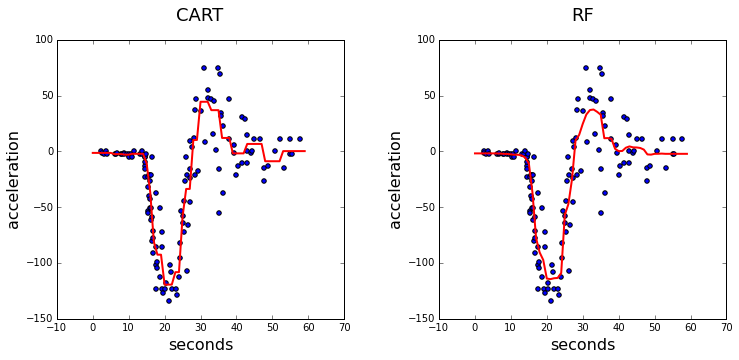

In [9]:
# a simple cart fit
mcycle_dt = tree.DecisionTreeRegressor(min_samples_leaf=5)
mcycle_dt.fit(Xm,ym)
# random forest 
mcycle_rf = ensemble.RandomForestRegressor(100,min_samples_leaf=5)
mcycle_rf.fit(Xm,ym)

# plot them
plt.figure(1)
plt.subplot(121)
mcycle_plot(mcycle_dt, "CART")

plt.subplot(122)
mcycle_plot(mcycle_rf, "RF")


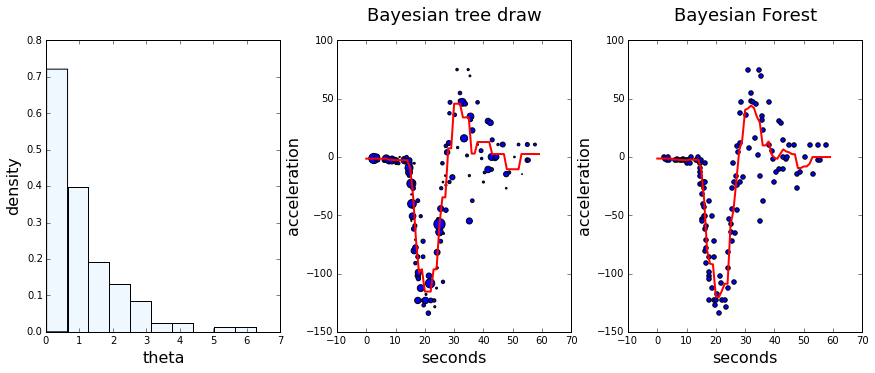

In [10]:
# single bayesian cart draw
omega = rn.exponential(1,mcycle.shape[0])
mcycle_bt = tree.DecisionTreeRegressor(min_samples_leaf=5)
mcycle_bt.fit(Xm, ym, sample_weight=omega)
# bayesian forest
mcycle_bf = ensemble.RandomForestRegressor(100,min_samples_leaf=5, bootstrap=2)
mcycle_bf.fit(Xm,ym)

plt.subplot(131)
plt.hist(omega,normed=1,color="aliceblue")
plt.xlabel("theta", fontsize=16)
plt.ylabel("density", fontsize=16)

plt.subplot(132)
mcycle_plot(mcycle_bt, "Bayesian tree draw", s=omega*20)

plt.subplot(133)
mcycle_plot(mcycle_bf, "Bayesian Forest")

plt.tight_layout(pad=.1,w_pad=0)


In [11]:
import sys
# give preference to local update
sys.path.append("~/.local/lib/python3.4/site-packages")

import numpy as np
import scipy as sp
import pandas as pd
import matplotlib.pyplot as plt
from sklearn import tree
from sklearn import ensemble
import numpy.random as rn

%matplotlib inline
plt.rc('figure', figsize=(14,6))
plt.rc('figure.subplot', wspace=.33)

def fried(x, noisy=True):
    f = 10*np.sin(np.pi*x[:,0]*x[:,1]) + 20*(x[:,2]-0.5)**2 + 10*x[:,3]+5*x[:,4]
    if noisy: 
        f += rn.normal(size=n)
    return f


(4, 26)

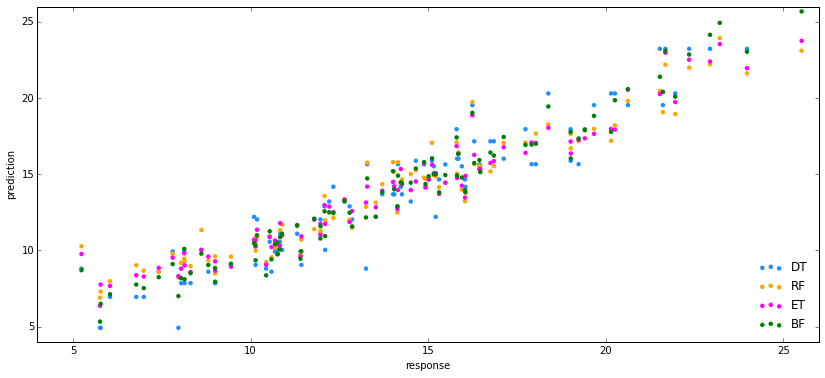

In [12]:
## a single analysis

n = 100
p = 10
X = rn.uniform(0,1,n*p).reshape(n,p)
y = fried(X)
f = fried(X,noisy=False)

#DT
fried_dt = tree.DecisionTreeRegressor(min_samples_leaf=3)
fried_dt.fit(X,y)
fried_dtp = fried_dt.predict(X)

#RF3
fried_rf = ensemble.RandomForestRegressor(100,min_samples_leaf=3)
fried_rf.fit(X,y)
fried_rfp = fried_rf.predict(X)

#ET
fried_et = ensemble.ExtraTreesRegressor(100,min_samples_leaf=3)
fried_et.fit(X,y)
fried_etp = fried_et.predict(X)

#BF
fried_bf = ensemble.RandomForestRegressor(100,min_samples_leaf=3,bootstrap=2)
fried_bf.fit(X,y)
fried_bfp = fried_bf.predict(X)

plt.scatter(f, fried_dtp, c="dodgerblue", label="DT",s=20,edgecolors='none')
plt.scatter(f, fried_rfp, c="orange", label="RF",s=20,edgecolors='none')
plt.scatter(f, fried_etp, c="fuchsia", label="ET",s=20,edgecolors='none')
plt.scatter(f, fried_bfp, c="green", label="BF",s=20,edgecolors='none')
plt.xlabel("response")
plt.ylabel("prediction")
plt.legend(frameon=False,loc=4)
plt.xlim(4,26)
plt.ylim(4,26)



In [13]:
def rmse(f,fhat):
    return np.sqrt(np.mean( (f-fhat)**2 ))


In [15]:

ne = 100
n = 100
p = 10
B = 100
msl = 3
fried_RMSE = {key: [] for key in ['DT','RF','ET','BF']}
for b in range(B):
    ### data
    Xtrain = rn.uniform(0,1,n*p).reshape(n,p)
    Xtest = rn.uniform(0,1,1000*p).reshape(1000,p)
    y = fried(Xtrain)
    f = fried(Xtest,noisy=False)
    
    #DT
    fried_dt = tree.DecisionTreeRegressor(min_samples_leaf=msl)
    fried_dt.fit(Xtrain,y)
    fried_dtp = fried_dt.predict(Xtest)
    fried_RMSE['DT'] += [rmse(f,fried_dtp)]
    
    #RF
    fried_rf = ensemble.RandomForestRegressor(n_estimators=ne,min_samples_leaf=msl)
    fried_rf.fit(Xtrain,y)
    fried_rfp = fried_rf.predict(Xtest)
    fried_RMSE['RF'] += [rmse(f,fried_rfp)]

    #ET
    fried_et = ensemble.ExtraTreesRegressor(n_estimators=ne,min_samples_leaf=msl)
    fried_et.fit(Xtrain,y)
    fried_etp = fried_et.predict(Xtest)
    fried_RMSE['ET'] += [rmse(f,fried_etp)]

    #BF
    fried_bf = ensemble.RandomForestRegressor(n_estimators=ne,bootstrap=2,min_samples_leaf=msl)
    fried_bf.fit(Xtrain,y)
    fried_bfp = fried_bf.predict(Xtest)
    fried_RMSE['BF'] += [rmse(f,fried_bfp)]

    print b,

fried_RMSE = pd.DataFrame(fried_RMSE)


0 1 2 3 4 5 6 7 8 9 10 11 12 13 14 15 16 17 18 19 20 21 22 23 24 25 26 27 28 29 30 31 32 33 34 35 36 37 38 39 40 41 42 43 44 45 46 47 48 49 50 51 52 53 54 55 56 57 58 59 60 61 62 63 64 65 66 67 68 69 70 71 72 73 74 75 76 77 78 79 80 81 82 83 84 85 86 87 88 89 90 91 92 93 94 95 96 97 98 99


bart     1.811829
ET       2.627936
BF       2.665485
RF       2.742198
DT       3.724362
bcart    3.910470
dtype: float64

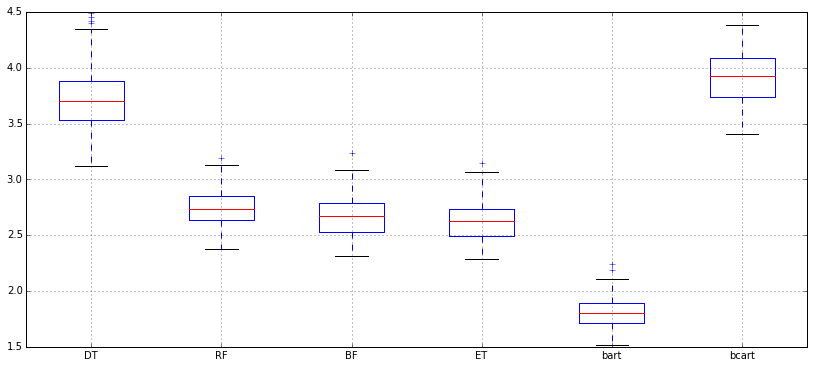

In [16]:
## cobine with output from code/bart.R, since this is not implemented in python
rdata = pd.read_table("graphs/bartfried.txt", sep=" ")
fried_RMSE = pd.concat([fried_RMSE,rdata])
fried_RMSE.boxplot(return_type='axes', column=['DT','RF','BF','ET','bart','bcart'])
fried_RMSE.mean().sort(inplace=False)


As predicted, the only model that assumes the (true) homoskedastic error structure, BART, well outperforms all others.  The two forests, BF and RF, are both a large improvement over a single decision tree.  The fully Bayesian BF is only about 1% better than the approximately Bayesian RF, as Bayesian and classical bootstrapping weights differ little in practice.  Both are outperformed slightly by the extremely random trees (ET), which might be expected due to the small sample size (for which the observed support approximation to population support, assumed in our forest interpretation, is poor).   The only suprise for us is the very poor performance of BCART (even worse than a single decision tree); we hypothesis that this is due to the notoriously poor mixing of the BCART MCMC, such that this fit is neither finding a posterior mean (as it is intended to) or optimizing to a local posterior mode (as DT does).

### California housing data

For the next example, we consider prediction of median home price by census block in california, based upon eight features of each region (location, income, housing stock).  The data are taken from http://www.dcc.fc.up.pt/~ltorgo/Regression/cal_housing.html.   This problem has a response distribution that is difficult to summarize parametrically.  Standard analysis takes the log price as the response of interest, which at least tames some of the error heteroskedasticity.  Instead, we will attempt to model the conditional expection of raw dollar home values.  This mimics the setting common in the analysis of online transaction data (e.g. clicks or dollars spent), where the variable average effects and predictive performance on raw $ or click scale are of primary interest.

['longitude', 'latitude', 'housingMedianAge', 'totalRooms', 'totalBedrooms', 'population', 'households', 'medianIncome', 'medianHouseValue']


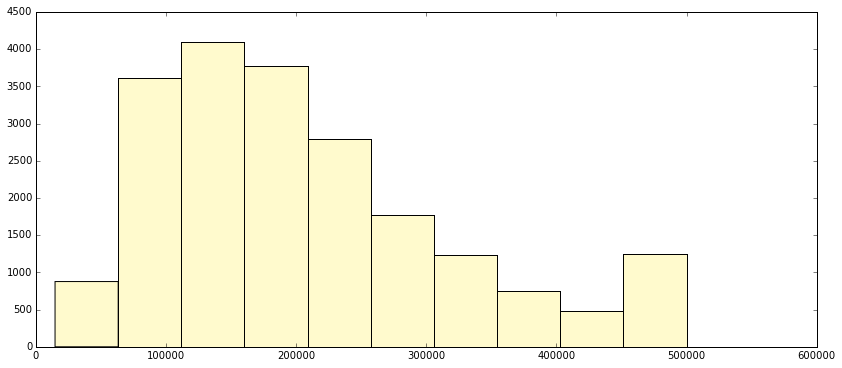

In [23]:
#### NB: this is the same data as:
# from sklearn.datasets import fetch_california_housing
# cah = fetch_california_housing(data_home="data")
# Xh = cah['data']
# yh = cah["target"]*1e5

cah = pd.read_csv('data/CAhousing.csv')
print(list(cah))
cah["medianIncome"] = cah["medianIncome"]*1e4
Xh = cah.drop("medianHouseValue",axis=1)
yh = cah["medianHouseValue"] 
cahist = plt.hist(cah["medianHouseValue"],color="lemonchiffon")

It appears from the histogram (and investigating the raw values) that the data has been capped at 500k.  In any case, the unconditional response has a long right tail, but is much more regular than what we commonly see in digital commerce applications (e.g., see Taddy et al, 2014, for transaction data with massive spikes at zero and at psychological price thresholds, as well as a tail that includes values 50k times larger than the mean).

In [24]:
from sklearn.cross_validation import KFold
kf = KFold(len(yh), n_folds=10,shuffle=True,random_state=5807)
## folds output for bart in R
import os
if not os.path.exists("data/cafolds"):
    os.makedirs("data/cafolds")
k=0
for train, test in kf:
    np.savetxt("data/cafolds/%d.txt"%k,test,fmt='%d')
    k+=1


In [25]:
## run our loop
ne = 100
msl = 2
cah_RMSE = {key: [] for key in ['DT','RF','ET','BF']}
k=0
for train, test in kf:
    
    ### data
    Xtrain = Xh.iloc[train].values
    Xtest = Xh.iloc[test].values
    ytrain = yh[train]
    ytest = yh[test]
    
    #DT
    cah_dt = tree.DecisionTreeRegressor(min_samples_leaf=msl)
    cah_dt.fit(Xtrain,ytrain)
    cah_dtp = cah_dt.predict(Xtest)
    cah_RMSE['DT'] += [rmse(ytest,cah_dtp)]
    
    #RF
    cah_rf = ensemble.RandomForestRegressor(n_estimators=ne,min_samples_leaf=msl,n_jobs=4)
    cah_rf.fit(Xtrain,ytrain)
    cah_rfp = cah_rf.predict(Xtest)
    cah_RMSE['RF'] += [rmse(ytest,cah_rfp)]

    #ET
    cah_et = ensemble.ExtraTreesRegressor(n_estimators=ne,min_samples_leaf=msl,n_jobs=4)
    cah_et.fit(Xtrain,ytrain)
    cah_etp = cah_et.predict(Xtest)
    cah_RMSE['ET'] += [rmse(ytest,cah_etp)]

    #BF
    cah_bf = ensemble.RandomForestRegressor(n_estimators=ne,bootstrap=2, n_jobs=4,
                                           min_weight_fraction_leaf=1e-4 )
    cah_bf.fit(Xtrain,ytrain)
    cah_bfp = cah_bf.predict(Xtest)
    cah_RMSE['BF'] += [rmse(ytest,cah_bfp)]
    
    print k, 
    k+=1

cah_RMSE = pd.DataFrame(cah_RMSE)
print("done")

0 1 2 3 4 5 6 7 8 9 done


Note that bart fit takes around 75 sec in R, vs 10 sec for BF run in serial.

bart-BF: 0.134464238422
ET-BF: 0.0876593517578
RF-BF: 0.00533741199049


BF       48264.709613
RF       48522.318253
ET       52495.562770
bart     54754.587034
DT       65625.138623
bcart    82695.262723
dtype: float64

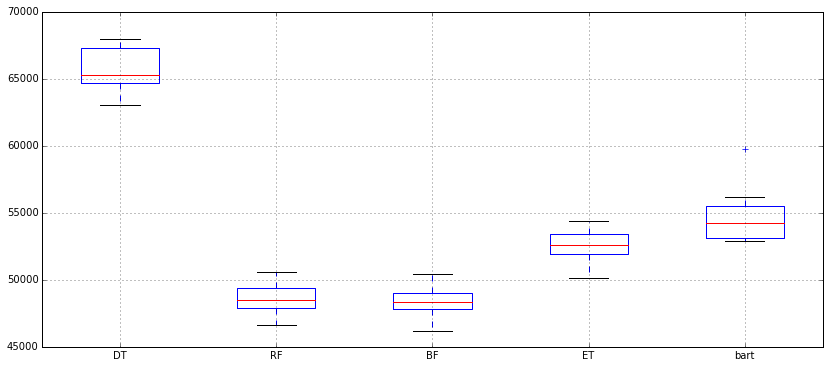

In [27]:
rdata = pd.read_table("graphs/bartca.txt", sep=" ")
cah_RMSE = pd.concat([cah_RMSE,rdata])
cah_RMSE.boxplot(return_type='axes', column=['DT','RF','BF','ET','bart'])
cah_MRMSE = cah_RMSE.mean()
print("bart-BF: " + str((cah_MRMSE["bart"]-cah_MRMSE["BF"])/cah_MRMSE["BF"]))
print("ET-BF: " + str((cah_MRMSE["ET"]-cah_MRMSE["BF"])/cah_MRMSE["BF"]))
print("RF-BF: " + str((cah_MRMSE["RF"]-cah_MRMSE["BF"])/cah_MRMSE["BF"]))
cah_MRMSE.sort(inplace=False)


The results are now reversed (except for DT and BCART, which still underperform all others).  The methods which place no assumptions on the data generating process, RF and BF, do much better than BART and it's restrictive error model.  The implicit regularization of extratrees is no longer of any benefit, as the larger sample size means that our finite support approximation is solid.  As always, BF offers a real but small gain over RF.

### tree stability in california

We'll illustrate trunk stability and the idea of EBFs on the California housing data from above.  To begin, consider a _trunk_ with no less than 3500 census blocks (out of 20640 total) in each leaf partition.  Greedy CART leads to a five node tree.

In [28]:
ca_trunk = tree.DecisionTreeRegressor(min_samples_leaf=3500)
ca_trunk.fit(Xh,yh)

DecisionTreeRegressor(criterion='mse', max_depth=None, max_features=None,
           max_leaf_nodes=None, min_samples_leaf=3500, min_samples_split=2,
           min_weight_fraction_leaf=0.0, random_state=None,
           splitter='best')

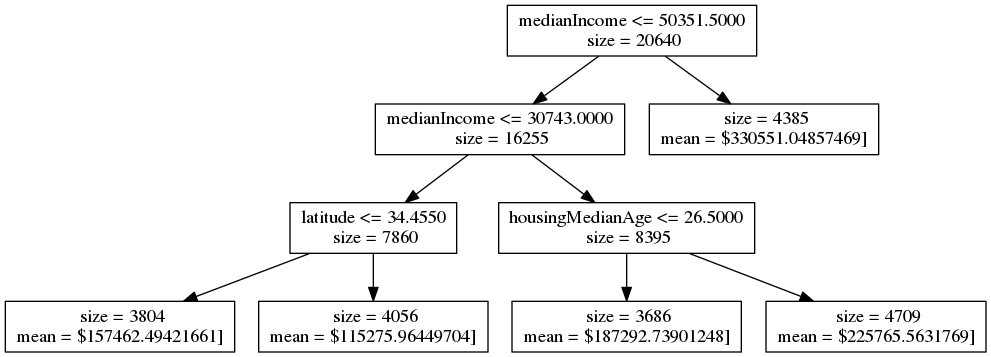

In [29]:
## plot it and show inline
tree.export_graphviz(ca_trunk,feature_names=list(Xh),out_file="graphs/catrunk.dot")
## a bunch of unescessary formatting (default is fine, but this is nicer)
!sed -i  's/mse = [0-9]*\.[0-9]*\\n/ /g' graphs/catrunk.dot
!sed -i  's/samples/size/g' graphs/catrunk.dot
!sed -i  's/\[ /\$/g' graphs/catrunk.dot
!sed -i  's/\.\]//g' graphs/catrunk.dot
!sed -i  's/value/mean/g' graphs/catrunk.dot

!dot -Tpng graphs/catrunk.dot -o graphs/catrunk.png
from IPython.display import Image
Image(filename='graphs/catrunk.png') 
# note that 34.5 degrees lat is just north of santa barbara

#### Shallow tree variance

The tree above represents the optimal (greedy) five partition CART.  As predicted by theory, it turns out to be very stable.  Running a random forest of trees which stop at this minimum leaf size, we get 

In [30]:
cah_forest = ensemble.RandomForestRegressor(n_estimators=100, bootstrap=2, n_jobs=4,
                                           min_samples_leaf=3500)
cah_forest.fit(Xh,yh)

RandomForestRegressor(bootstrap=2, criterion='mse', max_depth=None,
           max_features='auto', max_leaf_nodes=None, min_samples_leaf=3500,
           min_samples_split=2, min_weight_fraction_leaf=0.0,
           n_estimators=100, n_jobs=4, oob_score=False, random_state=None,
           verbose=0, warm_start=False)

In [31]:
trees = cah_forest.estimators_
var = list(Xh)
splitvar = [ [var[v] for v in t.tree_.feature if v >= 0] for t in trees ]

ts = ['medianIncome', 'medianIncome', 'latitude', 'housingMedianAge']
print "freq of CART tree",ts,": ",
print(sum( s == ts for s in splitvar ))

ts = ['medianIncome', 'medianIncome', 'latitude', 'medianIncome']
print "freq of  tree",ts,": ",
print(sum( s == ts for s in splitvar ))

ts = ['medianIncome', 'medianIncome', 'medianIncome']
print "freq of  tree",ts,": ",
print(sum( s == ts for s in splitvar ))

ts = ['medianIncome', 'medianIncome', 'medianIncome',"housingMedianAge"]
print "freq of  tree",ts,": ",
print(sum( s == ts for s in splitvar ))

ts = ['medianIncome', 'medianIncome', "housingMedianAge"]
print "freq of  tree",ts,": ",
print(sum( s == ts for s in splitvar ))

ts = ['medianIncome', 'medianIncome', 'latitude']
print "freq of first three",ts,": ",
print(sum( s[:3] == ts for s in splitvar ))

ts = ['medianIncome', 'medianIncome']
print "freq of first two",ts,": ",
print(sum( s[:2] == ts for s in splitvar ))

print "freq of any split on latitude",": ",
print(sum( 'latitude' in s for s in splitvar ))

print "freq of any split on housingMedianAge",": ",
print(sum( 'housingMedianAge' in s for s in splitvar ))


freq of CART tree ['medianIncome', 'medianIncome', 'latitude', 'housingMedianAge'] :  79
freq of  tree ['medianIncome', 'medianIncome', 'latitude', 'medianIncome'] :  9
freq of  tree ['medianIncome', 'medianIncome', 'medianIncome'] :  8
freq of  tree ['medianIncome', 'medianIncome', 'medianIncome', 'housingMedianAge'] :  2
freq of  tree ['medianIncome', 'medianIncome', 'housingMedianAge'] :  1
freq of first three ['medianIncome', 'medianIncome', 'latitude'] :  88
freq of first two ['medianIncome', 'medianIncome'] :  100
freq of any split on latitude :  88
freq of any split on housingMedianAge :  82


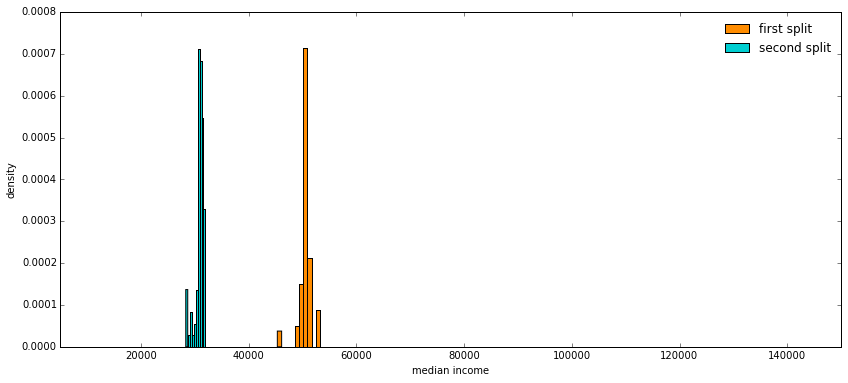

In [32]:

loc0 = [ t.tree_.threshold[0] for t in trees ]
loc1 = [ t.tree_.threshold[1] for t in trees ]

xlim = [min(Xh['medianIncome']),max(Xh['medianIncome'])]
plt.hist(loc0,color="darkorange",normed=True,label="first split")
plt.hist(loc1,color="darkturquoise",normed=True,label="second split")
plt.xlim(xlim)
plt.legend(frameon=False, loc='upper right')
plt.xlabel("median income")
plt.ylabel("density")


We can also repeatedly sample 90% of the data, and the CART fit with `min_sample_leaf=3500` is always similar: from visual inspection, each fold fit splits on the same variables, just on slightly different values.  Moreover, a Bayesian forest of trees limited to this node size does little better in OOS prediction (only 1%), offering additional evidence that the single CART fit is close to the posterior mean at this depth.

1.0

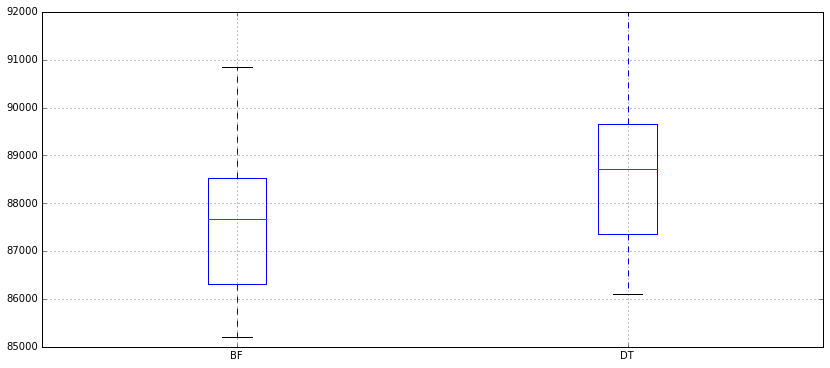

In [33]:
ne = 100
msl = 3500
shorte = {key: [] for key in ['DT','BF']}
def rmse(f,fhat):
    return np.sqrt(np.mean( (f-fhat)**2 ))

## run our loop
for train, test in kf:
    
    ### data
    Xtrain = Xh.iloc[train].values
    Xtest = Xh.iloc[test].values
    y = yh[train]
    f = yh[test]
    
    #DT
    cashort_dt = tree.DecisionTreeRegressor(min_samples_leaf=msl)
    cashort_dt.fit(Xtrain,y)
    cashort_dtp = cashort_dt.predict(Xtest)
    shorte['DT'] += [rmse(f,cashort_dtp)]
    
    #BF
    cashort_bf = ensemble.RandomForestRegressor(n_estimators=ne,bootstrap=2,min_samples_leaf=msl)
    cashort_bf.fit(Xtrain,y)
    cashort_bfp = cashort_bf.predict(Xtest)
    shorte['BF'] += [rmse(f,cashort_bfp)]

shorte = pd.DataFrame(shorte)
shorte.boxplot(return_type='axes')
mshorte = shorte.mean()
round((mshorte['DT']-mshorte['BF'])/mshorte['BF']*100)

#### OOS experiment

Finally, we consider OOS prediction for the EBF, using a trunk fixed at the shallow trees from above, and averaging of Bayesian forests fit to sub-samples of comparable size.  The EBF does around 8% better than random sub-sampling, and only around 2% worse than the BF fit to the entire dataset.

In [34]:
def EBF(x,y,test,f,k=None,mslpre=3000,nblock=5,pretree=True,ntree=100):
    if pretree: 
        dt = tree.DecisionTreeRegressor(min_samples_leaf=mslpre)
        dt.fit(x,y)
        bvec = dt.tree_.apply(x.astype(tree._tree.DTYPE))
        print "%d leaves" % sum(dt.tree_.feature < 0), 
#         tree.export_graphviz(dt,
#                             feature_names=list(Xh),
#                             out_file="data/cafolds/tree%d.dot"%k)
    else:
        bvec = rn.random_integers(0,nblock-1,x.shape[0])
        print "%d obs in train" % x.shape[0],
    bset = set(bvec)
    forest = {}
    for b in bset:
        print b, 
        forest[b] = ensemble.RandomForestRegressor(
                        ntree,bootstrap=1,min_samples_leaf=3,n_jobs=4)
        isb = bvec==b
        forest[b].fit(x[isb,:],y[isb])
    
    if pretree:
        yhat = np.empty(test.shape[0])
        btest = dt.tree_.apply(test.astype(tree._tree.DTYPE))
        for b in bset:
            print b, 
            isb = btest==b
            yhat[isb] = forest[b].predict(test[isb,:])
    else:
        yhat = np.zeros(test.shape[0])
        for b in bset:
            print b, 
            yhat += forest[b].predict(test)/float(len(bset))
            
    err = rmse(f,yhat)
    print(err)
    return err


In [35]:
sube = {key: [] for key in ['pretree','randsamp']}
k = 0
for train, test in kf:
    print(k)

    Xtrain = Xh.iloc[train].values
    Xtest = Xh.iloc[test].values
    y = yh[train]
    f = yh[test]
    
    sube['pretree'] += [EBF(Xtrain,y,Xtest,f,k=k)]
    sube['randsamp'] += [EBF(Xtrain,y,Xtest,f,k=k,pretree=False)]
    
    k+=1


0
5 leaves 8 3 4 6 7 8 3 4 6 7 51189.5497024
18576 obs in train 0 1 2 3 4 0 1 2 3 4 54173.7849077
1
5 leaves 8 3 4 6 7 8 3 4 6 7 49489.392238
18576 obs in train 0 1 2 3 4 0 1 2 3 4 54621.8849077
2
5 leaves 8 3 4 6 7 8 3 4 6 7 48604.7734913
18576 obs in train 0 1 2 3 4 0 1 2 3 4 51883.2640142
3
5 leaves 8 3 4 6 7 8 3 4 6 7 47056.0825164
18576 obs in train 0 1 2 3 4 0 1 2 3 4 50932.9975852
4
5 leaves 8 3 4 6 7 8 3 4 6 7 47775.3803647
18576 obs in train 0 1 2 3 4 0 1 2 3 4 51486.1576255
5
5 leaves 8 3 4 6 7 8 3 4 6 7 49012.0653597
18576 obs in train 0 1 2 3 4 0 1 2 3 4 52496.7402192
6
5 leaves 8 3 4 6 7 8 3 4 6 7 50261.7162109
18576 obs in train 0 1 2 3 4 0 1 2 3 4 54221.6178707
7
5 leaves 8 3 4 6 7 8 3 4 6 7 50266.2569771
18576 obs in train 0 1 2 3 4 0 1 2 3 4 55101.7102734
8
5 leaves 8 3 4 6 7 8 3 4 6 7 50099.0548723
18576 obs in train 0 1 2 3 4 0 1 2 3 4 54494.5183431
9
5 leaves 8 3 4 6 7 8 3 4 6 7 49714.0337745
18576 obs in train 0 1 2 3 4 0 1 2 3 4 53411.8844166


2.0% worse than full sample BF
8.0% better than random sub sampling


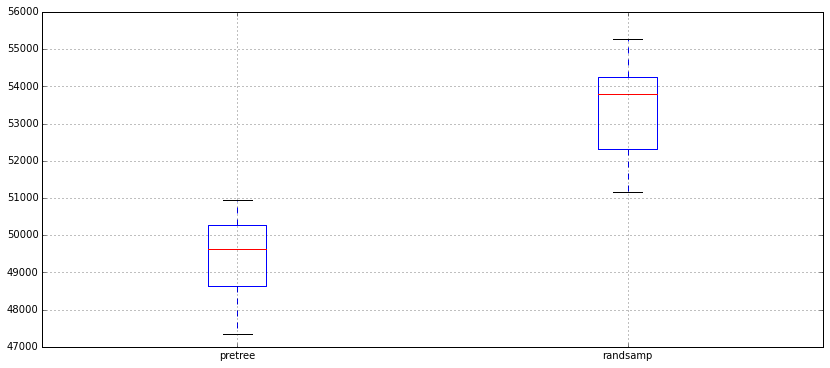

In [24]:
#!for K in `seq 0 9`; do dot -Tpdf data/cafolds/tree$K.dot -o data/cafolds/tree$K.pdf; done

sube = pd.DataFrame(sube)
sube.boxplot(return_type='axes')
msube = sube.mean()

print round((msube['pretree']-cah_MRMSE['BF'])/cah_MRMSE['BF']*100), "% ",
print("worse than full sample BF")
print round((msube['randsamp']-msube['pretree'])/msube['pretree']*100), "% ",
print("better than random sub sampling")


### Another example: wine quality

As another test of OOS performance, we consider the Vino Verde dataset of http://www3.dsi.uminho.pt/pcortez/wine/.   There are 4898 observations on 11 continuous attributes (physiochemical properties of the wine) plus wine color (red or white) as inputs, with an 'expert' quality ranking on the scale of 0-10 as response.  Here, we find that averaging forests fit to 5 random subsets of the data do 10% worse in OOS prediction than the EBF conditional on pre-tree partitioning into 5 leaves.  Here, the EBF does close to as well as a full forest: it is only 1% more expensive than the full BF fit.

['fixed.acidity', 'volatile.acidity', 'citric.acid', 'residual.sugar', 'chlorides', 'free.sulfur.dioxide', 'total.sulfur.dioxide', 'density', 'pH', 'sulphates', 'alcohol', 'quality', 'color']


(array([  10.,    0.,   53.,    0.,  681.,    0.,  638.,    0.,  199.,   18.]),
 array([ 3. ,  3.5,  4. ,  4.5,  5. ,  5.5,  6. ,  6.5,  7. ,  7.5,  8. ]),
 <a list of 10 Patch objects>)

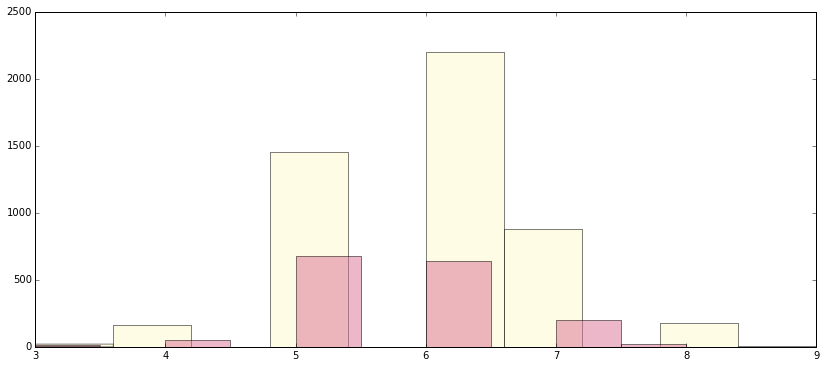

In [25]:
wine = pd.read_csv('data/wine.csv')
print(list(wine))
yw = wine["quality"] 
Xw = wine.drop("quality",axis=1)
Xw["color"] = (Xw["color"].values == "red").astype("int")
wine[wine.color == "white"]["quality"]
plt.hist(wine[wine.color == "white"]["quality"].values,alpha=0.5,color="lemonchiffon")
plt.hist(wine[wine.color == "red"]["quality"].values,alpha=0.5,color="palevioletred")


In [26]:
wine_RMSE = {key: [] for key in ['pretree','randsamp','fullbf']}
from sklearn.cross_validation import KFold
kw = KFold(len(yw), n_folds=10,shuffle=True,random_state=5807)

k = 0
for train, test in kw:
    print(k)

    Xtrain = Xw.iloc[train].values
    Xtest = Xw.iloc[test].values
    y = yw[train]
    f = yw[test]
    
    wine_RMSE['pretree'] += [EBF(Xtrain,y,Xtest,f,k=k,mslpre=1000)]
    wine_RMSE['randsamp'] += [EBF(Xtrain,y,Xtest,f,k=k,pretree=False)]
    wine_RMSE['fullbf'] += [EBF(Xtrain,y,Xtest,f,k=k,pretree=False,nblock=1)]

    k+=1


0
5 leaves 8 2 4 5 7 8 2 4 5 7 0.620392972682
5847 obs in train 0 1 2 3 4 0 1 2 3 4 0.673474573742
5847 obs in train 0 0 0.617286588523
1
4 leaves 2 4 5 6 2 4 5 6 0.65342357211
5847 obs in train 0 1 2 3 4 0 1 2 3 4 0.705536262655
5847 obs in train 0 0 0.654896994802
2
5 leaves 8 2 4 5 7 8 2 4 5 7 0.666675970556
5847 obs in train 0 1 2 3 4 0 1 2 3 4 0.724922808531
5847 obs in train 0 0 0.662875571152
3
5 leaves 8 2 4 5 7 8 2 4 5 7 0.575584866812
5847 obs in train 0 1 2 3 4 0 1 2 3 4 0.632799787875
5847 obs in train 0 0 0.564807376323
4
5 leaves 8 2 4 5 7 8 2 4 5 7 0.608842166257
5847 obs in train 0 1 2 3 4 0 1 2 3 4 0.670204696962
5847 obs in train 0 0 0.606176010593
5
5 leaves 8 2 4 5 7 8 2 4 5 7 0.60414093871
5847 obs in train 0 1 2 3 4 0 1 2 3 4 0.658878968991
5847 obs in train 0 0 0.606533453388
6
5 leaves 8 2 4 5 7 8 2 4 5 7 0.589246771508
5847 obs in train 0 1 2 3 4 0 1 2 3 4 0.671178294537
5847 obs in train 0 0 0.589898556987
7
5 leaves 8 2 4 5 7 8 2 4 5 7 0.610390984888
5848 obs

1.0% worse than full sample BF
10.0% better than random sub sampling


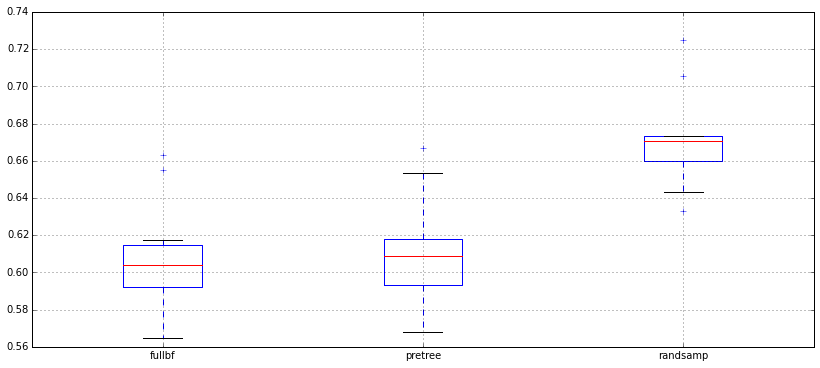

In [27]:
wine_RMSE = pd.DataFrame(wine_RMSE)
wine_RMSE.boxplot(return_type='axes')
wine_MRMSE = wine_RMSE.mean()

print round((wine_MRMSE['pretree']-wine_MRMSE['fullbf'])/wine_MRMSE['fullbf']*100), "% ",
print("worse than full sample BF")
print round((wine_MRMSE['randsamp']-wine_MRMSE['pretree'])/wine_MRMSE['pretree']*100), "% ",
print("better than random sub sampling")
